# Case 1. Heart Disease (binary) Classification (healthy/sick)

In [168]:
import time
import warnings
import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from keras.utils import to_categorical
from keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Activation

In [169]:
#reading the file and applying proper names for the columns
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(url,header=None,index_col=None,sep=',',na_values='?')
df.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach',
                'exang','oldpeak','slope','ca','thal','num']

#fill missing data with respective column's median value, then shuffle the rows
df = df.fillna(df.median())
df = shuffle(df)

df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.663366,4.722772,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,1.938383,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [170]:
#separate the data from the disease diagnosis
dataList = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach',
                'exang','oldpeak','slope','ca','thal']
data = df[dataList]

dataMin = data.min()
dataMax = data.max()
dataNorm = (data - dataMin)/(dataMax - dataMin)

labels = df['num']
#make it so diagnosis is either 1 or 0
labels = 1.0*(labels>0.0)

labelsOnehot = to_categorical(labels)

In [171]:
#200 rows for training, rest (103) for validation
trainData = dataNorm[:200]
valData = dataNorm[200:]

trainLabels = labelsOnehot[:200]
valLabels = labelsOnehot[200:]

print('Shape of')
print('  full data:        ',dataNorm.shape)
print('  train data:       ',trainData.shape)
print('  validation data:  ',valData.shape)
print('  one-hot-labels:   ',labelsOnehot.shape)
print('  train labels:     ',trainLabels.shape)
print('  validation labels:',valLabels.shape)

Shape of
  full data:         (303, 13)
  train data:        (200, 13)
  validation data:   (103, 13)
  one-hot-labels:    (303, 2)
  train labels:      (200, 2)
  validation labels: (103, 2)


In [172]:
#Building the model
model = Sequential()
model.add(layers.Dense(9, activation='relu', input_shape=(13,)))
model.add(layers.Dense(2, activation='softmax'))
model.summary()
#...and compiling it
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 9)                 126       
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 20        
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [173]:
# Fit the model with the data and keep record on elapsed time
trainStart = time.time()
history = model.fit(trainData, trainLabels, 
                    epochs = 50, 
                    batch_size = 10, 
                    verbose = 0,
                    validation_data = (valData, valLabels))
trainEnd = time.time()
print('Elapsed time: {:.2f} seconds'.format(trainEnd - trainStart))

Elapsed time: 1.30 seconds


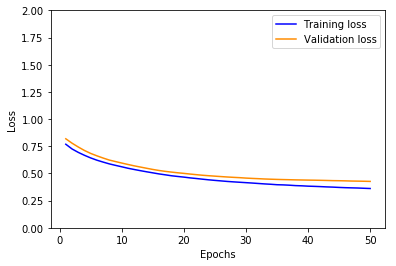

In [174]:
#get the data from the training
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

#plotting a figure for training loss
plt.figure()
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'darkorange', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend()
plt.show()

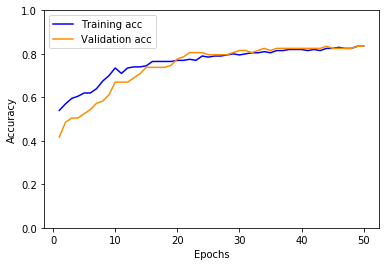

In [175]:
#plotting a figure for training accuracy
plt.figure()
plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'darkorange', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [176]:
# Print total accuracy and confusion matrix
valPredicts = model.predict(dataNorm)
y_pred = argmax(valPredicts, axis = 1)

# Best guess = Guess that all are normal
simpleGuess = zeros(len(y_pred))
cm0 = confusion_matrix(labels, simpleGuess)
true0 = np.trace(cm0)
N = len(labels)
acc0 = true0/N
print('Simple guess accuracy: {:.4f}'.format(acc0))
print('Confusion matrix:')
print(cm0)

#printing total accuracy
print(' ')
cm1 = confusion_matrix(labels, y_pred)
true1 = np.trace(cm1)
N = len(labels)
acc1 = true1/N
print('Total accuracy: {:.4f}'.format(acc1))
print('Confusion matrix:')
print(cm1)

Simple guess accuracy: 0.5413
Confusion matrix:
[[164   0]
 [139   0]]
 
Total accuracy: 0.8317
Confusion matrix:
[[142  22]
 [ 29 110]]
